# Regresión lineal como red neuronal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mxnet import autograd, gluon, np, npx
import mxnet as mx

from my_wrapper import wrapper as myw

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt

import pandas as pd

npx.set_np()

**Librería propia: ```my_wrapper```**

Importamos una librería propia que envuelve la implementación de modelos en gluon para que estos sean compatibles con la librería sklearn

## Obtener los datos

### Cargar desde .csv

In [3]:
df = pd.read_csv('housing.csv')

X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values.reshape(-1,)

## Semilla

Para que se puedan replicar los experimentos (por ejemplo la inicialización aleatoria de los pesos de la red neuronal que creemos):

In [4]:
mx.random.seed(128)

## Definición de la red y otros parámetros

### Funciones de creación

Definimos funciones que generen un modelo de red neuronal de la forma propia de la API de gluon:

In [5]:
def basic_net():
    net = gluon.nn.Sequential()

    net.add(gluon.nn.Dense(1))
    
    return net

### Función de pérdida

También definimos la función de pérdida, que se utilizará en el entrenamiento del modelo.

In [6]:
loss = gluon.loss.L2Loss()

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Búsqueda del mejor ```alpha```

In [8]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

net = myw.GluonRegressor(model_function=basic_net, loss_function=loss,
                         batch_size=200, epochs=2000, optimizer='adam')

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])
    
scaler = StandardScaler()
ttr = TransformedTargetRegressor(regressor=pipe,
                                 transformer=scaler)

l_alpha = [10.**k for k in range(-10, 2)]
grid_params = {'regressor__net__alpha': l_alpha} 


grid_search = GridSearchCV(ttr, grid_params, cv=kfold,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           verbose=1)

grid_search.fit(X, y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('std_sc',
                                                                             StandardScaler()),
                                                                            ('net',
                                                                             GluonRegressor(batch_size=200,
                                                                                            epochs=2000,
                                                                                            loss_function=L2Loss(batch_axis=0, w=1.0),
                                                                                            model_function=<function basic_net at 0x7fc33b3d4820>,
                                                                                            optimizer='adam'))]),
                                                  transfor

In [9]:
grid_search.best_params_

{'regressor__net__alpha': 0.1}

### Evolución con cambio de ```alpha```

Rango de 'alpha': 0.000000 - 10.00
Mejor 'alpha' = 0.100000
Mejor puntuación = 3.330


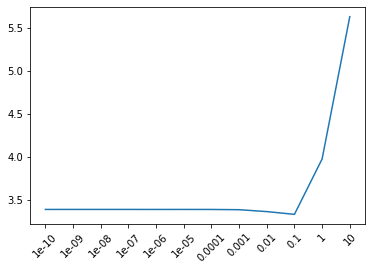

In [10]:
alpha_range = [10**k for k in range(-10, 2)]
print("Rango de 'alpha': %f - %.2f" % (np.array(alpha_range).min(), np.array(alpha_range).max()))
print("Mejor 'alpha' = %f" % (grid_search.best_params_['regressor__net__alpha']))
print("Mejor puntuación = %.3f" % (-grid_search.best_score_))

plt.xticks(range(len(alpha_range)), alpha_range, rotation=45)
_ = plt.plot( -grid_search.cv_results_['mean_test_score'])

## Validación cruzada

```cross_val_predict```

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

y_pred_cv = cross_val_predict(grid_search.best_estimator_, X, y, cv=kfold)

In [12]:
print("MAE: %.3f\t" % (mean_absolute_error(y, y_pred_cv)))

MAE: 3.330	


In [13]:
print("MSE: %.3f\t" % (mean_squared_error(y, y_pred_cv)))

MSE: 24.314	


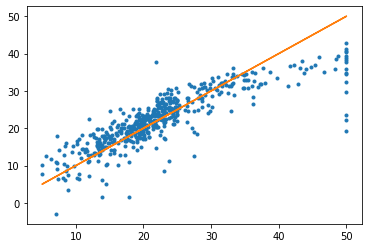

In [14]:
_ = plt.plot(y, y_pred_cv, '.', y, y, '-')

# MLPRegressor de scikit-learn

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

net = MLPRegressor(hidden_layer_sizes=(), solver='adam', max_iter=2000)

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])

In [16]:
scaler = StandardScaler()
ttr = TransformedTargetRegressor(regressor=pipe,
                                 transformer=scaler)

l_alpha = [10.**k for k in range(-15, 6)]
grid_params = {'regressor__net__alpha': l_alpha} 


grid_search = GridSearchCV(ttr, grid_params, cv=kfold,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           n_jobs=4,
                           verbose=1)

grid_search.fit(X, y)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('std_sc',
                                                                             StandardScaler()),
                                                                            ('net',
                                                                             MLPRegressor(hidden_layer_sizes=(),
                                                                                          max_iter=2000))]),
                                                  transformer=StandardScaler()),
             n_jobs=4,
             param_grid={'regressor__net__alpha': [1e-15, 1e-14, 1e-13, 1e-12,
                                                   1e-11, 1e-10, 1e-09, 1e-08,
                                                   1e-07, 1e-06, 1e-05, 0.0001,
                                                   0.001, 0.01, 0.1, 1.0, 10.0,
                       

Rango de 'alpha': 0.000000 - 100000.00
Mejor 'alpha' = 0.000100
Mejor puntuación = 3.400


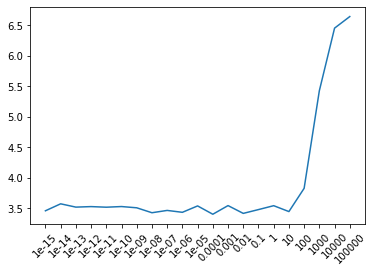

In [17]:
alpha_range = [10**k for k in range(-15, 6)]
print("Rango de 'alpha': %f - %.2f" % (np.array(alpha_range).min(), np.array(alpha_range).max()))
print("Mejor 'alpha' = %f" % (grid_search.best_params_['regressor__net__alpha']))
print("Mejor puntuación = %.3f" % (-grid_search.best_score_))

plt.xticks(range(len(alpha_range)), alpha_range, rotation=45)
_ = plt.plot( -grid_search.cv_results_['mean_test_score'])

## Validación cruzada

In [18]:
yp = cross_val_predict(grid_search.best_estimator_, X, y, cv=kfold)

In [19]:
from sklearn.metrics import mean_absolute_error

print("MAE: %.3f\t" % (mean_absolute_error(y, yp)))

MAE: 3.432	


In [20]:
from sklearn.metrics import mean_squared_error

print("MSE: %.3f\t" % (mean_squared_error(y, yp)))

MSE: 25.243	


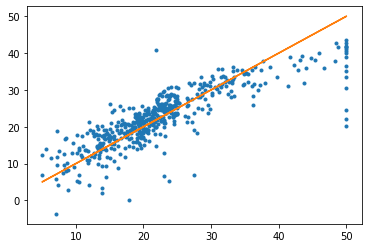

In [21]:
import matplotlib.pyplot as plt

_ = plt.plot(y, yp, '.', y, y, '-')

# Ridge de scikit-learn

In [22]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

net = Ridge()

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])

In [23]:
scaler = StandardScaler()
ttr = TransformedTargetRegressor(regressor=pipe,
                                 transformer=scaler)

l_alpha = [10.**k for k in range(-15, 6)]
grid_params = {'regressor__net__alpha': l_alpha} 


grid_search = GridSearchCV(ttr, grid_params, cv=kfold,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           n_jobs=4,
                           verbose=1)

grid_search.fit(X, y)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('std_sc',
                                                                             StandardScaler()),
                                                                            ('net',
                                                                             Ridge())]),
                                                  transformer=StandardScaler()),
             n_jobs=4,
             param_grid={'regressor__net__alpha': [1e-15, 1e-14, 1e-13, 1e-12,
                                                   1e-11, 1e-10, 1e-09, 1e-08,
                                                   1e-07, 1e-06, 1e-05, 0.0001,
                                                   0.001, 0.01, 0.1, 1.0, 10.0,
                                                   100.0, 1000.0, 10000.0,
                                                   100000.0]},
             retur

Rango de 'alpha': 0.000000 - 100000.00
Mejor 'alpha' = 10.000000
Mejor puntuación = 3.349


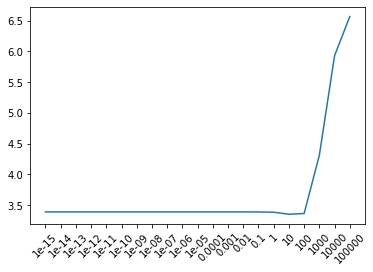

In [24]:
alpha_range = [10**k for k in range(-15, 6)]
print("Rango de 'alpha': %f - %.2f" % (np.array(alpha_range).min(), np.array(alpha_range).max()))
print("Mejor 'alpha' = %f" % (grid_search.best_params_['regressor__net__alpha']))
print("Mejor puntuación = %.3f" % (-grid_search.best_score_))

plt.xticks(range(len(alpha_range)), alpha_range, rotation=45)
_ = plt.plot( -grid_search.cv_results_['mean_test_score'])

## Validación cruzada

In [25]:
yp = cross_val_predict(grid_search.best_estimator_, X, y, cv=kfold)

In [26]:
from sklearn.metrics import mean_absolute_error

print("MAE: %.3f\t" % (mean_absolute_error(y, yp)))

MAE: 3.350	


In [27]:
from sklearn.metrics import mean_squared_error

print("MSE: %.3f\t" % (mean_squared_error(y, yp)))

MSE: 23.712	


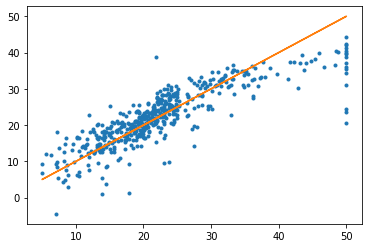

In [28]:
import matplotlib.pyplot as plt

_ = plt.plot(y, yp, '.', y, y, '-')